In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
path = untar_data(URLs.IMAGEWOOF); path.ls(), len(get_image_files(path/'train'))

((#3) [/home/jupyter/.fastai/data/imagewoof/models,/home/jupyter/.fastai/data/imagewoof/val,/home/jupyter/.fastai/data/imagewoof/train],
 12454)

In [6]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=lambda x: x,
                 )

In [7]:
bs, sz = 32, 64
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])
dbch.c = 3

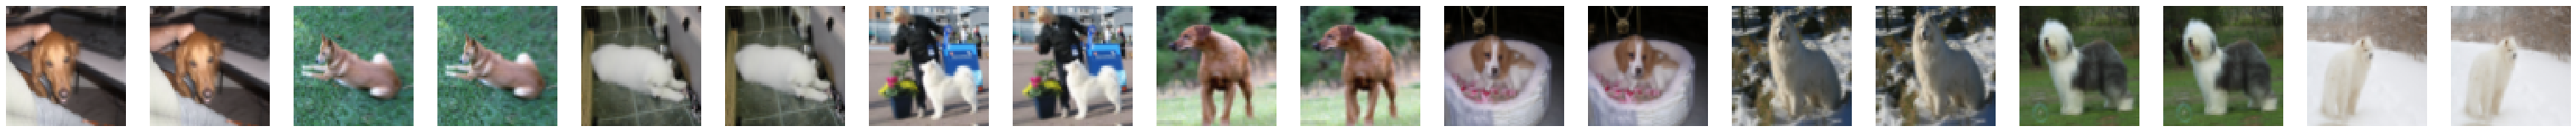

In [9]:
dbch.show_batch(rows=1)

In [10]:
# How can I be sure this is working correctly?
pipe = Pipeline([PILImage.create, Resize(sz), ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe('styles/udnie.jpg').cuda())

In [11]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw):
        super().__init__()
        store_attr(self, 'm_feat,cnt_ls,stl_ls,cnt_lsw,stl_lsw')
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        
    def register_style(self, timg):
        # Features of style img, only needs to be computed once
        cnt_fs,stl_fs = self.get_fs(timg)
        self._stl_fs = stl_fs
#         self.style_fs = [o.repeat(bs,1,1,1) for o in stl_fs]

    # TODO: Doing this dynamically because of shape problem in validation
    def get_stl_fs(self, bs): return [o.repeat(bs,1,1,1) for o in self._stl_fs]
        
    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
#         stl_loss = self._stl_loss(pred_stl_fs)
#         cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        stl_loss2 = self._cnt_loss(pred,style_timg,pred_stl_fs,targ_stl_fs)
        return stl_loss2 #+ cnt_loss # Add a weight for each loss
        
    def _stl_loss(self, pred_fs):
        stl_fs = self.get_stl_fs(bs=pred_fs[0].shape[0])
        stl_loss = [base_loss(gram(pred_f),gram(style_f)*w**2*5e3)
                    for pred_f,style_f,w in zip(pred_fs,stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w**2*5e3 for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
for p in vgg_m.parameters(): p.requires_grad = False
requires_grad(vgg_m)

False

In [15]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
ls = [vgg_m[i] for i in blocks]

In [16]:
fst_loss = FSTLoss(vgg_m, cnt_ls =ls[2:5] , stl_ls= ls[1:4],
                          cnt_lsw=[5,15,2], stl_lsw=[15, 5, 2])
fst_loss.register_style(style_timg)

In [17]:
opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, **kwargs))

In [18]:
config = dict(blur=True, self_attention=True, y_range=(-3, 3), norm_type=NormType.Batch)
learn = unet_learner(dbch, partial(xresnet50, sa=True), loss_func=fst_loss, opt_func=opt_func, config=config)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

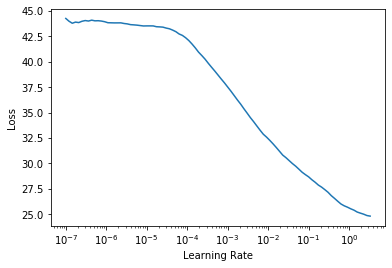

In [13]:
learn.lr_find()

In [19]:
learn.fit_flat_cos(1, 1e-2)

epoch,train_loss,valid_loss,time
0,4.357542,3.434643,03:16


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([48, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([48, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([48, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


ValueError: cannot copy sequence with size 10 to array axis with dimension 12

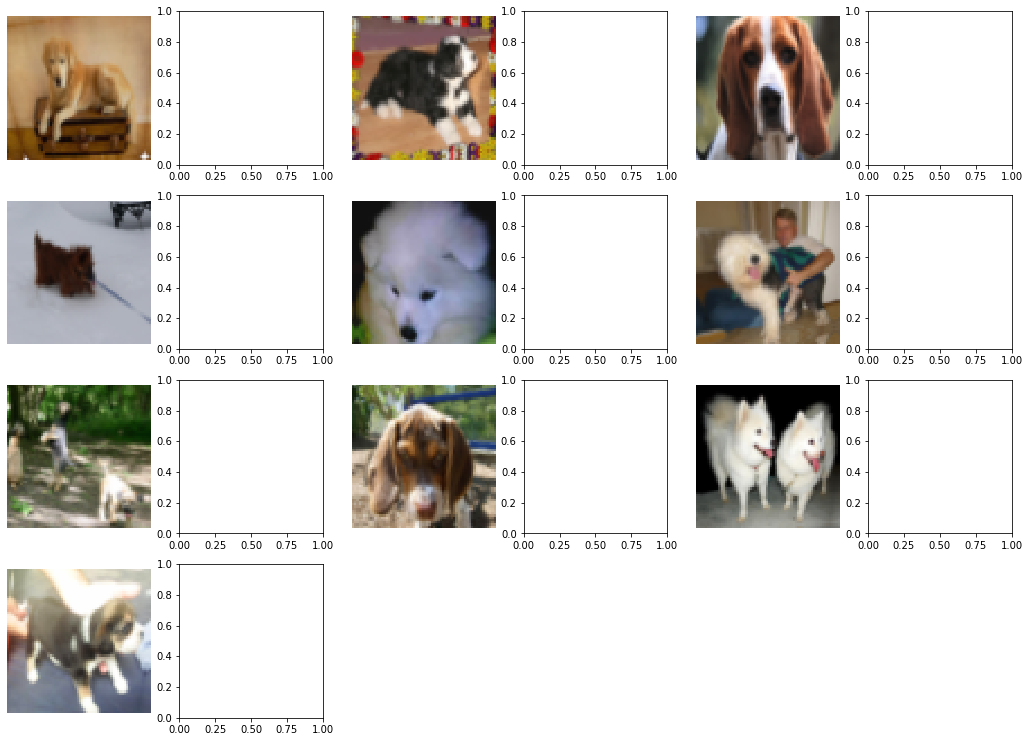

In [20]:
learn.show_results()

In [ ]:
%debug

> /home/jupyter/fastai_dev/fastai2/vision/learner.py(165)show_results()
    163     if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize, double=True)
    164     for i in range(2):
--> 165         ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[::2],range(max_n))]
    166     for x in [samples,outs]:
    167         ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(x.itemgot(0),ctxs[1::2],range(max_n))]

ipdb> print(b)
*** NameError: name 'b' is not defined
ipdb> l
    160 #Cell
    161 @typedispatch
    162 def show_results(x:TensorImage, y:(TensorImageBase, TensorPoint, TensorBBox), samples, outs, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    163     if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize, double=True)
    164     for i in range(2):
--> 165         ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in z

ipdb> samples
(#10) [(tensor([[[0.6980, 0.7019, 0.6968,  ..., 0.6591, 0.6509, 0.6372],
         [0.6763, 0.6946, 0.6865,  ..., 0.6751, 0.6664, 0.6518],
         [0.6476, 0.6618, 0.6555,  ..., 0.6896, 0.6814, 0.6665],
         ...,
         [0.3842, 0.4130, 0.4271,  ..., 0.8209, 0.5663, 0.4879],
         [0.3846, 0.4219, 0.4333,  ..., 0.9659, 0.8040, 0.5755],
         [0.4316, 0.4764, 0.4360,  ..., 0.8044, 0.5506, 0.4913]],

        [[0.5362, 0.5406, 0.5342,  ..., 0.5041, 0.4933, 0.4708],
         [0.5134, 0.5256, 0.5133,  ..., 0.5220, 0.5088, 0.4896],
         [0.4797, 0.4868, 0.4775,  ..., 0.5396, 0.5251, 0.5074],
         ...,
         [0.2164, 0.2462, 0.2559,  ..., 0.7651, 0.4192, 0.3026],
         [0.2089, 0.2481, 0.2610,  ..., 0.9587, 0.7472, 0.4335],
         [0.2460, 0.2957, 0.2584,  ..., 0.7443, 0.3978, 0.3062]],

        [[0.3413, 0.3457, 0.3398,  ..., 0.3639, 0.3504, 0.3137],
         [0.3181, 0.3305, 0.3179,  ..., 0.3801, 0.3635, 0.3362],
         [0.2817, 0.2865, 0.2738,  .

ipdb> len(samples)
10
ipdb> ctxs[::2]
array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f46f93db0d0>,
      dtype=object)
ipdb> len(ctxs[::2])
12
ipdb> u
> /home/jupyter/fastai_dev/fastai2/core/dispatch.py(98)__call__()
     96         if not f: return args[0]
     97         if self.inst is not None: f = types.MethodType(f, self.inst)
---> 98         return f(*args, **kwargs)
     99 
    100     def __get__(self, inst, owner):

ipdb> d
> /home/jupyter/fastai_dev/fastai2/vision/learner.py(165)show_results()
    163     if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize, double=True)
    164     for i in range(2):
--> 165         ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[::2],range(max_n))]
    166     for x in [samples,outs]:
    167         ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(x.itemgot(0),ctxs[1::2],range(max_n))]

ipdb> l
    160 #Cell
    161 @typedispatch
    1

ipdb> samples.itemgot(i)
(#10) [tensor([[[0.6980, 0.7019, 0.6968,  ..., 0.6591, 0.6509, 0.6372],
         [0.6763, 0.6946, 0.6865,  ..., 0.6751, 0.6664, 0.6518],
         [0.6476, 0.6618, 0.6555,  ..., 0.6896, 0.6814, 0.6665],
         ...,
         [0.3842, 0.4130, 0.4271,  ..., 0.8209, 0.5663, 0.4879],
         [0.3846, 0.4219, 0.4333,  ..., 0.9659, 0.8040, 0.5755],
         [0.4316, 0.4764, 0.4360,  ..., 0.8044, 0.5506, 0.4913]],

        [[0.5362, 0.5406, 0.5342,  ..., 0.5041, 0.4933, 0.4708],
         [0.5134, 0.5256, 0.5133,  ..., 0.5220, 0.5088, 0.4896],
         [0.4797, 0.4868, 0.4775,  ..., 0.5396, 0.5251, 0.5074],
         ...,
         [0.2164, 0.2462, 0.2559,  ..., 0.7651, 0.4192, 0.3026],
         [0.2089, 0.2481, 0.2610,  ..., 0.9587, 0.7472, 0.4335],
         [0.2460, 0.2957, 0.2584,  ..., 0.7443, 0.3978, 0.3062]],

        [[0.3413, 0.3457, 0.3398,  ..., 0.3639, 0.3504, 0.3137],
         [0.3181, 0.3305, 0.3179,  ..., 0.3801, 0.3635, 0.3362],
         [0.2817, 0.2865, 

ipdb> len(samples.itemgot(i))
10
ipdb> l
    171 @typedispatch
    172 def plot_top_losses(x: TensorImage, y:TensorCategory, samples, outs, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    173     axs = get_grid(len(samples), rows=rows, cols=cols, add_vert=1, figsize=figsize, title='Prediction/Actual/Loss/Probability')
    174     for ax,s,o,r,l in zip(axs, samples, outs, raws, losses):
    175         s[0].show(ctx=ax, **kwargs)
    176         ax.set_title(f'{o[0]}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')
    177 
    178 #Cell
    179 @typedispatch
    180 def plot_top_losses(x: TensorImage, y:TensorMultiCategory, samples, outs, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    181     axs = get_grid(len(samples), rows=rows, cols=cols, add_vert=1, figsize=figsize)

ipdb> d
*** Newest frame
ipdb> u
> /home/jupyter/fastai_dev/fastai2/core/dispatch.py(98)__call__()
     96         if not f: return args[0]
     97         if self.inst is not None: 